<a href="https://colab.research.google.com/github/CHUNGSEYEON991108/Credit12/blob/main/20240927_Model_3_feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#딥러닝 모델을 만든 이유(피드백): 신용카드 이상거래가 데이터상에서 측정되어, 딥러닝 모델을 활용하여 효과적으로 신용카드 이상거래를 탐지 하기 위함

#Module

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, classification_report, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE # For Oversampling
from sklearn.preprocessing import MinMaxScaler # Data Normalization (각 특징에 대해 0~1 사이 값으로 변환)
from sklearn.model_selection import StratifiedKFold #TrainData, TestData 분리(K-fold)
from sklearn.model_selection import train_test_split #피드백으로 추가한 부분

# Data Load

In [2]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Detect credit card anomalies/creditcard.csv'
data = pd.read_csv(file_path)

Mounted at /content/drive


# EDA

In [3]:
# data.info() #결측치 없음
data['Class'].value_counts()

,count
Class,
0,284315
1,492


# 원본 데이터 시각화

<ipython-input-4-993f4f3db8c2>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


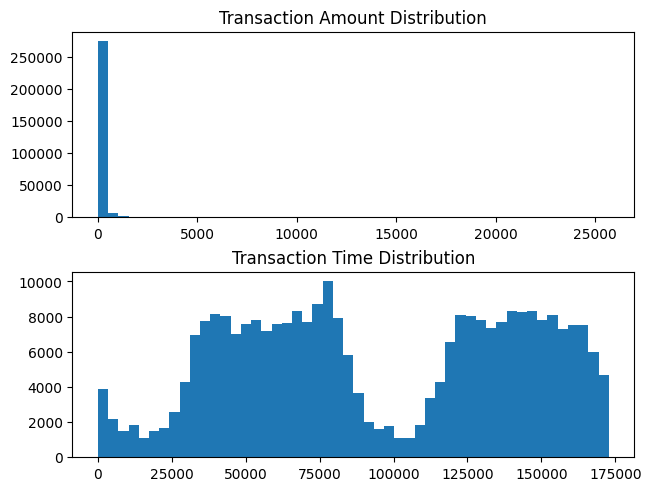

In [4]:
amount_original = data['Amount'].values
time_original = data['Time'].values

plt.subplots(constrained_layout=True)

plt.subplot(2, 1, 1)
plt.title('Transaction Amount Distribution')
plt.hist(amount_original, bins=50)

plt.subplot(2, 1, 2)
plt.title('Transaction Time Distribution')
plt.hist(time_original, bins=50)

plt.show()

# TrainData TestData 분리, Oversampling, Data Normalization

##Kfold 할때 test셋을 먼저 빼놓고 나머지 80으로 kfold했어야한다(Training Data를 만들었어야만 했다).

In [8]:
# 1. X, y 분리
X= data.iloc[:, :-1] # Time~Amount
Y= data.iloc[:, -1] # Class

# 2. 데이터 정규화 (각 특징에 대해 0~1 사이 값으로 변환), 데이터 분리전 데이터 정규화를 하도록 코드 순서 변경(피드백)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X) # X데이터를 scaling
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) # X_scaled는 numpy이므로 DataFrame으로 변경

# 3. Train Data와 Test Data 분리(피드백으로 추가한 부분)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# 4. Oversampling(피드백으로 Oversampling 알고리즘 변경
smote = SMOTE(random_state=0)
X_resampled, Y_resampled = smote.fit_resample(X_train, y_train)

# 5. train, test 분리
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

for train_index, val_index in kfold.split(X_resampled, Y_resampled):
    X_train, X_val = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
    y_train, y_val = Y_resampled.iloc[train_index], Y_resampled.iloc[val_index]

print(X_train.shape, y_train.shape) #(363904, 30) (363904,) 80% (Test_Set 없음)
print(X_val.shape, y_val.shape) #(90976, 30) (90976,) 20% (Test_Set 없음)

(363904, 30) (363904,)
(90976, 30) (90976,)


In [10]:
Y_resampled.value_counts() #Over Sampling check, 피드백대로 수정한 결과 28만개에서 22만개로 감소

,count
Class,
0,227440
1,227440


# 정규화된 데이터 시각화

<ipython-input-11-174f209d2bbb>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


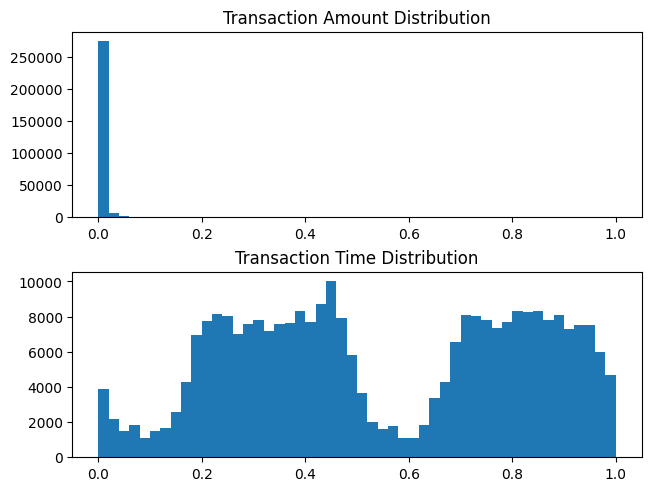

In [11]:
amount_normalized = X['Amount'].values
time_normalized = X['Time'].values

plt.subplots(constrained_layout=True)

plt.subplot(2, 1, 1)
plt.title('Transaction Amount Distribution')
plt.hist(amount_normalized, bins=50)

plt.subplot(2, 1, 2)
plt.title('Transaction Time Distribution')
plt.hist(time_normalized, bins=50)

plt.show()

# Hyperparameter

## learning_rate_decay 변경
     exponential -> cosine -> inverse


##EXP(Learning_Rate_Decay)

In [ ]:
# 초기값 설정
initial_learning_rate = 0.01
decay_steps = 5
decay_rate = 0.95
epochs = np.arange(1, 101)

#Exponential Decay
exponential_decay = tf.keras.optimizers.schedules.ExponentialDecay(
     initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate
 )


# 2. 배치크기
batch_size = 2**12 #13만 #train 데이터의 약 50%크기

##Cosine Decay(Learning_Rate_Decay)

In [ ]:
#Cosine Decay
CosineDecayValue=tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.01,
    decay_steps=100,
    alpha=0.001,
    # name='CosineDecay',
    warmup_target=None,
    warmup_steps=0
)
epochs = np.arange(1, 101)

# 2. 배치크기
batch_size = 2**12 #13만 #train 데이터의 약 50%크기

##Inverse(Learning_Rate_Decay)

In [14]:
#Inverse
InverseValue=tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=20,
    decay_rate=0.95,
    staircase=False,
    name='InverseTimeDecay'
)
epochs = np.arange(1, 101)

# 2. 배치크기
batch_size = 2**12 #13만 #train 데이터의 약 50%크기

## Learning Rate Decay Visualization

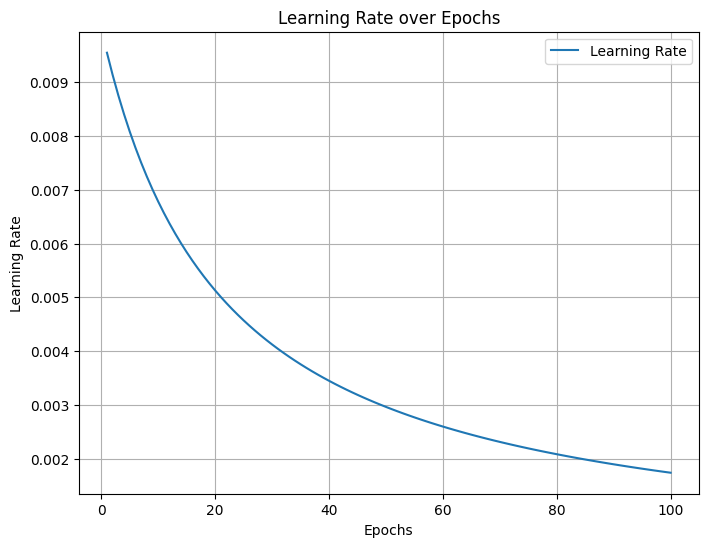

In [15]:
# Learning_Rate 체크
learning_rate_check = []
for epoch in epochs:
    learning_rate = InverseValue(epoch)
    learning_rate_check.append(learning_rate.numpy())

# 학습율 시각화
plt.figure(figsize=(8, 6))
plt.plot(epochs, learning_rate_check, label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Model 구축

## Model 초기화

In [16]:
print(X_train.shape[1])

30


In [21]:
model = Sequential()

#가중치 초기화(Weight Initailization)
# weight_init = tf.keras.initializers.he_uniform()
# weight_init = tf.keras.initializers.RandomNormal()
weight_init = tf.keras.initializers.glorot_uniform()

#model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu', input_dim=30, kernel_initializer=weight_init))  # 첫 번째 은닉층
model.add(Dropout(0.5)) # 50% 드롭아웃 적용
model.add(Dense(64, activation='relu',kernel_initializer=weight_init))  # 두 번째 은닉층
model.add(Dropout(0.5))  # 50% 드롭아웃 적용
model.add(Dense(32, activation='relu',kernel_initializer=weight_init)) # 세 번째 은닉층
model.add(Dense(1, activation='sigmoid'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 128)                 │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,337 (56.00 KB)

 Trainable params: 14,337 (56.00 KB)

 Non-trainable params: 0 (0.00 B)

# Model Complie

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=InverseValue),
              loss = 'binary_crossentropy',
              metrics = ['recall'])

# Model Training

In [23]:
#생성된 데이터를 batch_size로 나누어, epoch만큼 학습시킴
history = model.fit(X_train, y_train, epochs=len(epochs), validation_data=(X_val, y_val), batch_size = batch_size)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.3387 - recall: 0.7934 - val_loss: 0.1443 - val_recall: 0.9047
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1541 - recall: 0.9139 - val_loss: 0.1312 - val_recall: 0.9140
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1419 - recall: 0.9218 - val_loss: 0.1224 - val_recall: 0.9250
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1323 - recall: 0.9277 - val_loss: 0.1151 - val_recall: 0.9315
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.1281 - recall: 0.9302 - val_loss: 0.1076 - val_recall: 0.9385
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.1221 - recall: 0.9335 - val_loss: 0.1038 - val_recall: 0.9373
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1184 - recall: 0.9361 - val_loss: 0.0995 - val_recall: 0.9407
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1162 - recall: 0.9384 - val_loss: 0.0972 - val_recall: 0.9381
Epoch 9/

## Training Loss and Val_Loss Visualization

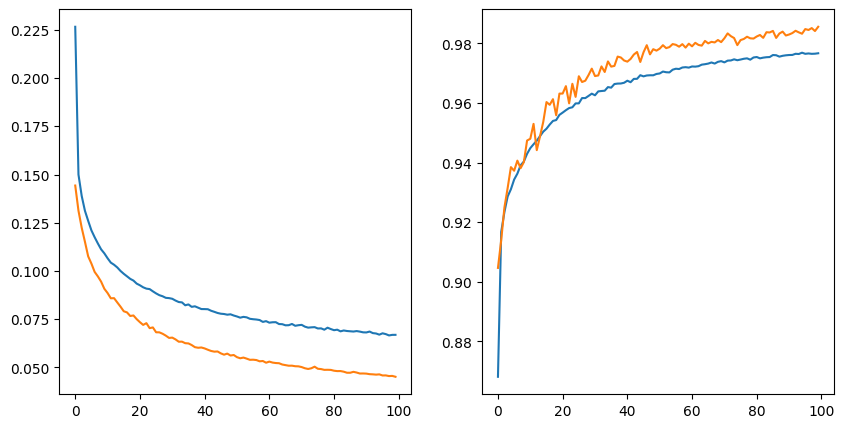

In [25]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(history_df.loc[:, ['loss', 'val_loss']])
plt.subplot(122)
plt.plot(history_df.loc[:, ['recall', 'val_recall']])

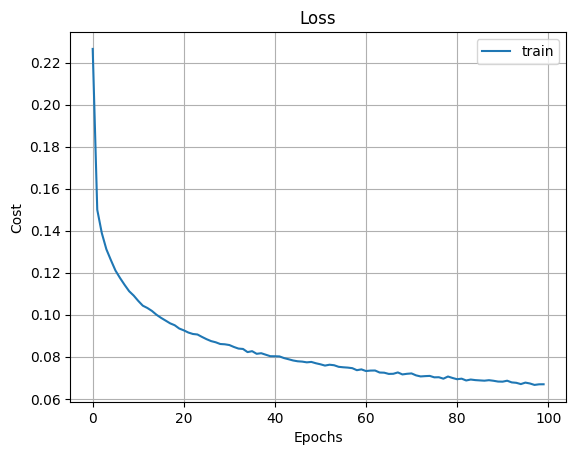

In [26]:
plt.plot(history.history['loss'], label = "train")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title('Loss')
plt.grid()
plt.legend()
plt.show()

# Model Evaluation

In [27]:
eval_loss, eval_acc = model.evaluate(X_test, y_test) # 피드백 대로, Test_Set 분리 한 후, accuracy를 확인 한 결과, accuracy가 감소 했다
print(f"evaluation_acc = {eval_acc}")
print(f"evaluation_loss = {eval_loss}")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0413 - recall: 0.8315
evaluation_acc = 0.8505747318267822
evaluation_loss = 0.04018441587686539


#Model Test

In [37]:
y_pred = model.predict(X_test)

print(y_pred[0])
print(y_test)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
[7.553288e-05]
169876    0
127467    0
137900    0
21513     0
134700    0
         ..
230213    0
275519    0
148273    0
77261     0
73202     0
Name: Class, Length: 56962, dtype: int64


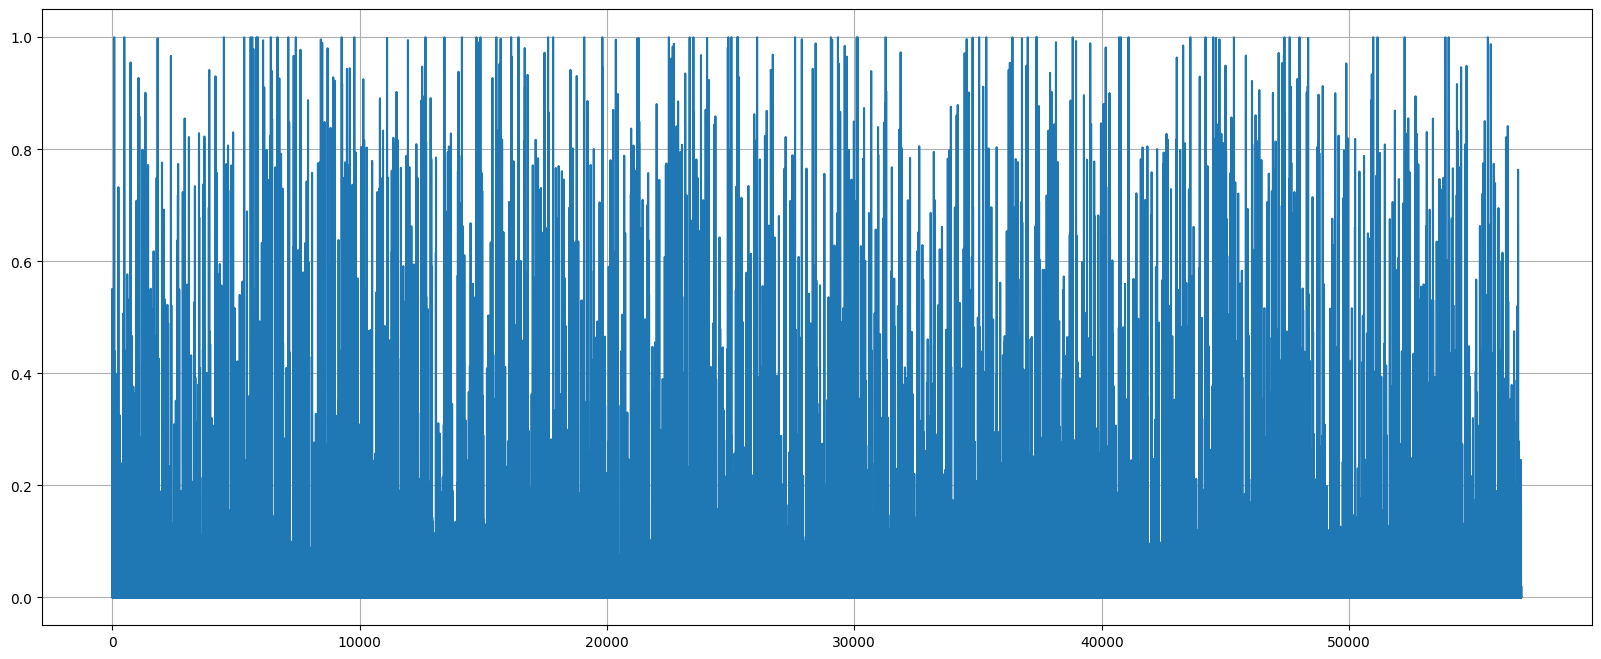

In [40]:
plt.figure(figsize=(20,8)) #그래프 가로사이즈를 '10'으로 설정했을시, 0과1의 구별이 어려움
plt.plot(y_pred) #그래프모양 변경가능
plt.grid()
plt.show()

In [33]:
y_pred_class = np.where(y_pred > 0.5, 1 , 0)
y_pred_class=pd.DataFrame(y_pred_class)
y_pred_class.value_counts()

,count
0,
0,56090
1,872


#Recall

In [34]:
y_pred_class = np.where(y_pred > 0.5, 1 , 0) #0.5보다크면 1, 작으면 0
print(recall_score(y_test, y_pred_class))

0.8505747126436781


In [43]:
y_test.value_counts()

,count
Class,
0,56875
1,87


#Confusion Matrix(피드백: 실제 판별건수를 혼동행렬에 추가)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


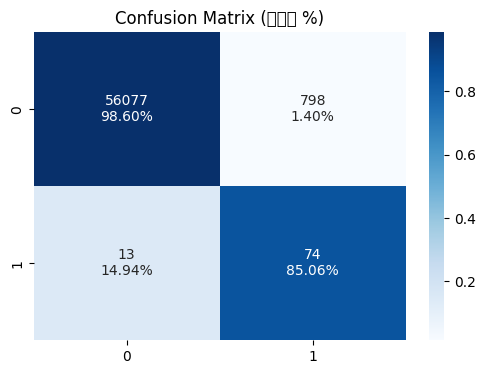

In [55]:
# Confusion Matrix 계산 (건수)
cm_count = confusion_matrix(y_test, y_pred_class, labels=[0, 1], normalize=None)

# Confusion Matrix 계산 (%)
cm_percent = confusion_matrix(y_test, y_pred_class, labels=[0, 1], normalize='true')


plt.figure(figsize=(6, 4))


labels = np.asarray([f"{int(cm_count[i, j])}\n{cm_percent[i, j]:.2%}" for i in range(2) for j in range(2)]).reshape(2, 2)


sns.heatmap(cm_percent, annot=labels, fmt='', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title("Confusion Matrix (건수와 %)")
plt.show()

# ROC Curve

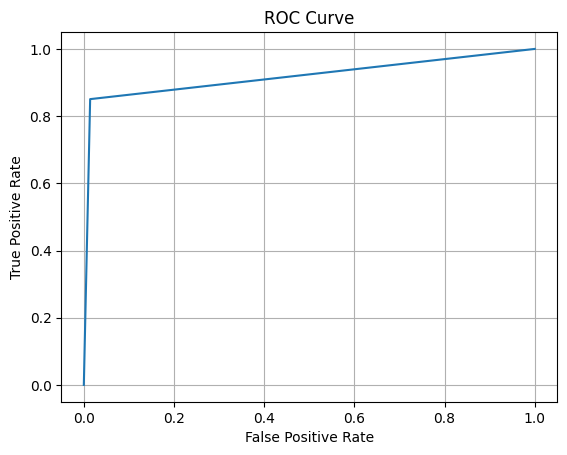

In [36]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_class)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

# AUC

In [38]:
print(roc_auc_score(y_test, y_pred_class))

0.9182719717064546
